In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Slides Irina

In [3]:
df = pd.read_csv("data/df_final.csv")
df_kunden = pd.read_csv("data/kunden.csv", delimiter=";")
df_besucher = pd.read_csv("data/cleaned_besucher.csv")

## 1. Wie viele Autos wurden verkauft?

In [4]:
df_autos = df[df["Preis"] > 0]
df_autos["Preis"].count()

1104

## 2. Was ist der Höchst-, Mindest- und Durchschnittspreis der verkauften Autos?

In [5]:
df_autos["Preis"].describe().round(2)[["min", "max", "mean"]]

min      21471.65
max     165482.31
mean     88975.20
Name: Preis, dtype: float64

## 3. Wie hoch war der Gesamtumsatz?

In [6]:
df_autos["Preis"].sum().round(2)

98228619.38

## 4. Wie viele Autos wurden pro Bundesland verkauft?

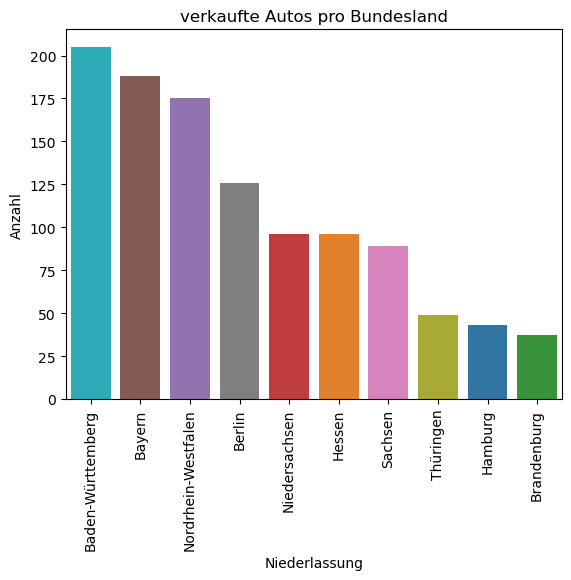

In [7]:
bundesland_order = ["Baden-Württemberg", "Thüringen", "Berlin", "Sachsen",
                    "Bayern", "Nordrhein-Westfalen", "Niedersachsen",
                    "Brandenburg", "Hessen", "Hamburg"]

color_palette = {}
for i, color in enumerate(sns.color_palette().as_hex()[::-1]):
    color_palette[bundesland_order[i]] = color

niederlassung_count = df_autos['Niederlassung'].value_counts()
niederlassung_count_plot = sns.barplot(x=niederlassung_count.index,
                                       y=niederlassung_count.values,
                                       hue=niederlassung_count.index,
                                      palette=color_palette)
_ = plt.setp(niederlassung_count_plot.get_xticklabels(), rotation=90)
plt.ylabel('Anzahl')
_ = plt.title('verkaufte Autos pro Bundesland')

## 19. Auf welche Probleme sind Sie bei der Zusammenführung des Datensatzes gestoßen? Stellen Sie die Operationen vor, die Sie zum Zusammenführen und Bereinigen der Daten durchgeführt haben.

### Ausreißer

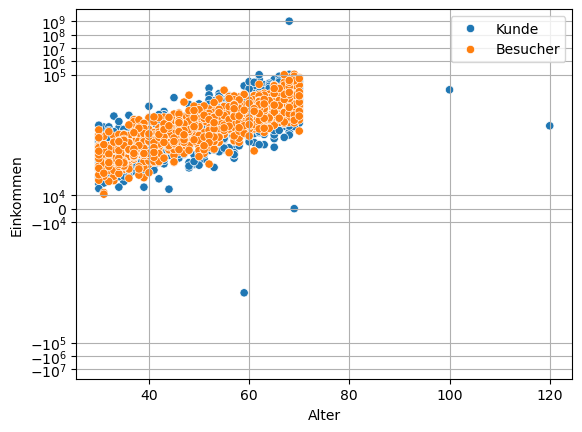

In [15]:
# Zusammenführen der unbereinigten Kundendaten mit den bereinigten Besucher Daten (richtige Formate)
combined_df = df_kunden.merge(df_besucher, how='outer', on=['KundeNr', 'Alter', 'Einkommen', 'Geschlecht', 'Zeit'])

# Auffüllen der NaNs insbesondere für die Spalte Preis bei den Besuchern (kein Kauf)
combined_df = combined_df.fillna(0)

# Neue Spalte "Gruppe" zur besseren Visualisierung im Streudiagramm
combined_df.loc[combined_df['Preis'] > 0, 'Gruppe'] = "Kunde"
combined_df.loc[combined_df['Preis'] == 0, 'Gruppe'] = "Besucher"

# Streudiagramm Einkommen und Alter
# farbliche Unterscheidung zwischen Kunden und Besucher (Gruppe)
ax = sns.scatterplot(data=combined_df, x="Alter", y="Einkommen", hue="Gruppe")

# legt die Position der Legende fest und löscht den Titel "Gruppe" in der Legende
ax.legend(loc=0)

# fügt Linien hinzu, sodass die Werte besser abgelesen werden können
plt.grid(True)

# legt die y-Achsen Limits fest, sodass der größte Wert (10^9) nicht abgeschnitten wird
plt.yticks(np.logspace(-5, 9.9))

# macht den Bereich 99999 bis 10^4, -10^4 bis -99999 linear
# vergrößert außerdem den linearen Bereich um den Faktor 9
# -> Streuung der Daten in dem Bereich besser veranschaulicht
plt.yscale('symlog', linthresh=99999, linscale=9)

### Ausreißer in der Datei kunden.csv

Alter:
- 100 und 120 sind nicht realitische Alter für Autokäufer
- Die nächste Person im Datensatz ist 70 Jahre alt
- Beide Einträge werden durch den Modalwert ersetzt

```python
age_mode = cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] < 70, 'Alter'].mode()[0]
cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] > 70, 'Alter'] = age_mode
```

Einkommen:
- 1 Mrd. und 0 sind unrealistische Jahresgehälter, weshalb sie durch den Median ersetzt werden
- Modalwert nicht möglich, da alles Einkommensangaben einzigartig sind

```python
income_median = cleaned_kunden_df.loc[(cleaned_kunden_df['Einkommen'] < 1000000) & (cleaned_kunden_df['Einkommen'] != 0), 'Einkommen'].median()
cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] > 1000000, 'Einkommen'] = income_median
cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] == 0, 'Einkommen'] = income_median
```

### fehlende Daten in der Datei kunden.csv

Die Datei enthält 5 Reihen, wo das Geschlecht nicht ausgefüllt ist (isnull())

```python
cleaned_kunden_df = kunden_df.fillna(1.0)
```

### falsche Daten in der Datei kunden.csv

- die Datei enthält eine Reihe, wo das Gehalt negativ ist
- es wird davon ausgegangen, dass es sich hierbei um einen Tippfehler handelt

```python
cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] < 0, 'Einkommen'] *= -1
```

### nicht-normalisierte Daten in der Datei geo.txt

- Düsseldorf, NRW und Nordrhein-Westfalen beschreiben das gleiche Bundesland, sind aber unterschiedlich angegeben

```python
cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'NRW', 'Niederlassung'] = 'Nordrhein-Westfalen'
cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'Düsseldorf', 'Niederlassung'] = 'Nordrhein-Westfalen'
```

- Berlin, BERLIN, Berlin-Charlottenburg und Berlin-Mitte beschreiben ebenfalls das gleiche Bundesland

```python
cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'BERLIN', 'Niederlassung'] = 'Berlin'
cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'].str.startswith('Berlin-'), 'Niederlassung'] = 'Berlin'
```

### inkonsequente Datenformate

- Einkommen ist in kunden.csv float64, in besucher.csv object
- Geschlecht ist in kunden.csv float64, in besucher.csv int64
- Zeit ist in kunden.csv float64, in besucher.csv object

```python
cleaned_besucher_df['Einkommen'] = cleaned_besucher_df['Einkommen'].str.replace(',', '.')
cleaned_besucher_df['Zeit'] = cleaned_besucher_df['Zeit'].str.replace(',', '.')
cleaned_besucher_df = cleaned_besucher_df.astype({'Geschlecht': 'float64', 'Einkommen': 'float64', 'Zeit': 'float64'})
```

### Zusammenführen

![Visualisierung der Merge Typen in Pandas](https://miro.medium.com/v2/resize:fit:400/format:webp/1*9eH1_7VbTZPZd9jBiGIyNA.png)

- Die Daten werden mithilfe eines Outer Joins zusammengeführt.
- Die NaN Werte, die dabei für die Besucher in der Spalte 'Preis' entstehen, werden im Anschluss durch 0 ersetzt.

```python
combined_df = cleaned_kunden_df.merge(cleaned_besucher_df, how='outer', on=['KundeNr', 'Alter', 'Einkommen', 'Geschlecht', 'Zeit'])
combined_df = combined_df.merge(cleaned_geo_df, how='outer', on='KundeNr')
combined_df = combined_df.fillna(0)
```

- Ausreißer
  - bei kunden_df:
    - Alter: 100 und 120 sind nicht realistische Alter für Autokäufer. Die nächste Person im Datensatz ist 70 Jahre alt. Die beiden       Einträge werden durch den Modalwert ersetzt.
      - `age_mode = cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] < 70, 'Alter'].mode()[0]`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] > 70, 'Alter'] = age_mode`
    - Einkommen: 1.000.000.000 (1 Mrd) und Einkommen 0 sind unrealistische Jahresgehälter, weshalb es durch den Median ersetzt wird (Modalwert nicht möglich, da alle Einkommensangaben einzigartig sind).
      - `income_median = cleaned_kunden_df.loc[(cleaned_kunden_df['Einkommen'] < 1000000) & (cleaned_kunden_df['Einkommen'] != 0), 'Einkommen'].median()`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] > 1000000, 'Einkommen'] = income_median`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] == 0, 'Einkommen'] = income_median`
- fehlende Daten
  - kunden_df enthält 5 Reihen, wo das Geschlecht nicht ausgefüllt ist (isnull())
    - `cleaned_kunden_df = kunden_df.fillna(1.0)`
- falsche Daten
  - kunden_df enthält einen Reihe, wo das Gehalt negativ ist. Es wird davon ausgegangen, dass es sich hierbei um einen Tippfehler handelt
    - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] < 0, 'Einkommen'] *= -1` 
- nicht normalisierte Daten
  - geo_df enthält Unstimmigkeiten in der Spalte Niederlassung:
    - Düsseldorf, NRW und Nordrhein-Westfalen beschreiben das gleiche Bundesland, sind aber unterschiedlich angegeben.
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'NRW', 'Niederlassung'] = 'Nordrhein-Westfalen'`
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'Düsseldorf', 'Niederlassung'] = 'Nordrhein-Westfalen'`
    - Berlin, BERLIN, Berlin-Charlottenburg und Berlin-Mitte beschreiben ebenfalls das gleiche Bundesland.
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'BERLIN', 'Niederlassung'] = 'Berlin'`
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'].str.startswith('Berlin-'), 'Niederlassung'] = 'Berlin'`
- Inkonsequente Datenformate
  - Einkommen: ist in kunden_df float64, in besucher_df object
  - Geschlecht: ist in kunden_df float64, in besucher_df int64
  - Zeit: ist in kunden_df float64, in besucher_df object
  - `cleaned_besucher_df['Einkommen'] = cleaned_besucher_df['Einkommen'].str.replace(',', '.')`
  - `cleaned_besucher_df['Zeit'] = cleaned_besucher_df['Zeit'].str.replace(',', '.')`
  - `cleaned_besucher_df = cleaned_besucher_df.astype({'Geschlecht': 'float64', 'Einkommen': 'float64', 'Zeit': 'float64'})`
- Zusammenführen
  - Die Daten werden mithilfe eines Outer Joins zusammengeführt. Die NaN Werte, die dabei für die Besucher in der Spalte 'Preis' entstehen, werden im Anschluss durch 0 ersetzt.
  - `combined_df = combined_df.merge(cleaned_besucher_df, how='outer', on=['KundeNr', 'Alter', 'Einkommen', 'Geschlecht', 'Zeit'])`
  - `combined_df = combined_df.merge(cleaned_geo_df, how='outer', on='KundeNr')`
  - `combined_df = combined_df.fillna(0)`

![Visualisierung der Merge Typen in Pandas](https://miro.medium.com/v2/resize:fit:400/format:webp/1*9eH1_7VbTZPZd9jBiGIyNA.png)

Für eine ausführliche Betrachtung des Data Cleanings, siehe Datei : data_cleaning.ipynb


## 20. Welche Vorschläge würden Sie der Kundenabteilung für die Umfrage im nächsten Jahr machen? Welche zusätzlichen Informationen sollten gesammelt werden? Formulieren Sie zwei Vorschläge.

- clean data:
  - alle Daten im richtigen Format anlegen bzw. übereinstimmend über Dateien hinweg (z.B. feste Feldformatierung)
  - bei Niederlassung/Bundesländern nur vorbestimmte Antworten zulassen (z.B. über ein Dropdown Menü)
  - Regeln für Dateneingabe einführen (z.B. Einkommen muss > 0 sein)

- neue Daten:
  - welches Modell wurde gekauft (Kundensegmentierung)  
  - welches Modell wurde angeschaut/getestet (Conversion Rate) 
  - wodurch auf Elektratuto AG aufmerksam geworden (Marketing)